In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import GroundwaterDupuitPercolator, FlowAccumulator


Text(0.5, 1.0, 'Topographic Elevation')

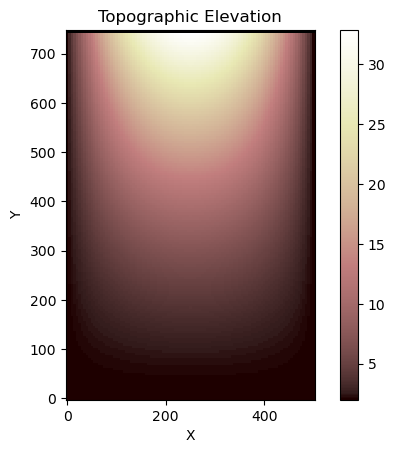

In [2]:
boundaries = {"top": "closed", "left": "open", "bottom": "open", "right": "open"}

Nx = 101; Ny = 150; dx = 5
mg = RasterModelGrid((Ny,Nx), xy_spacing=dx, bc=boundaries)
z = mg.add_zeros('topographic__elevation', at='node')
zb = mg.add_zeros('aquifer_base__elevation', at='node')
zwt = mg.add_zeros("water_table__elevation", at="node")

# some parameters
b = 2 # permeable thickness m
r = 1.0e-7 # recharge rate (constant, uniform here) m/s
ksat = 1e-4 # hydraulic conductivity (constant, uniform here) m/s
n = 0.1 # porosity (constant, uniform here) -- does not matter for steady state solution
routing_method = 'MFD' # could also be 'D8' or 'Steepest'

# some example parabolic hillslopes, just made up
x = mg.x_of_node
y = mg.y_of_node
a = 0.0005
z[:] = (-a*(x-np.median(x))**2 + np.max(a*(x-np.median(x))**2)) * y**2/(np.max(y**2)) + b
# z[:] = (-a*(x-np.median(x))**2 + np.max(a*(x-np.median(x))**2)) * y**0.5/(np.max(y**0.5))  + b

zb[:] = z - b # set constant permeable thickness b
zwt[:] = z # start water table at the surface

# topography
plt.figure()
imshow_grid(mg,z)
plt.title('Topographic Elevation')

In [ ]:
# 3D plot of the hillslope
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = x.reshape(mg.shape)
Y = y.reshape(mg.shape)
Z = z.reshape(mg.shape)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='pink',
                       linewidth=0, antialiased=False)

In [ ]:
#%% Initialize components

# initialize the groundwater model
gdp = GroundwaterDupuitPercolator(
    mg,
    recharge_rate=r,
    hydraulic_conductivity=ksat,
    porosity=n,
)

# initialize flow accumulation -- "surface_water__specific_discharge" is the basic runoff field
# it records discharge at the end of the timestep. When you use the adaptive timestep solver to 
# update the gdp, you also get the field "average_surface_water__specific_discharge". This is the 
# average local runoff at the end of the subtimesteps that the model takes to meet stability criteria.
fa = FlowAccumulator(
    mg,
    surface="topographic__elevation",
    flow_director=routing_method,
    runoff_rate="surface_water__specific_discharge",
)

In [ ]:
# %% run to steady state

diff = 1
tol = 1e-10
while diff > tol:
    zwt0 = zwt.copy()
    gdp.run_with_adaptive_time_step_solver(1e5)
    diff = np.max(zwt0-zwt)
    print(diff)

gwf = gdp.calc_gw_flux_at_node() # map groundwater flux to node (easier to plot)
fa.run_one_step() # calculate flow directions and route surface water (if any is generated)


In [ ]:
# %%
plt.figure()
imshow_grid(mg, gwf, cmap='plasma')
plt.title('Groundwater Flux at Node')

In [ ]:
plt.figure()
imshow_grid(mg, 'surface_water__specific_discharge', cmap='viridis')
plt.title('Local Runoff')

In [ ]:
plt.figure()
imshow_grid(mg, 'surface_water__discharge', cmap='viridis')
plt.title('Surface Water Discharge')

In [ ]:
plt.figure()
imshow_grid(mg, (zwt-zb)/(z-zb), cmap='Blues')
plt.title('Relative Saturated Thickness')

In [ ]:
a